## Importing Necessary Libraries

In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import networkx as nx

## Loading the Data

In [45]:
data = pd.read_csv("traffic-prediction-dataset.csv")
data

,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6
0,105.0,48.0,30,62.0,31,110.0
1,97.0,41.0,32,55.0,42,103.0
2,76.0,47.0,44,58.0,40,100.0
3,98.0,40.0,39,59.0,43,104.0
4,87.0,41.0,47,49.0,35,112.0
...,...,...,...,...,...,...
16123,85.0,37.0,34,56.0,35,89.0
16124,71.0,45.0,44,50.0,44,53.0
16125,83.0,34.0,34,61.0,44,77.0
16126,89.0,39.0,25,48.0,32,64.0


## Data Preprocessing

In [46]:
start_time = pd.to_datetime('2024-01-01 08:00:00')
data['timestamp'] = [start_time + pd.Timedelta(minutes=5 * i) for i in range(len(data))]
data = data.set_index(pd.to_datetime(data['timestamp']))
data = data.drop(columns='timestamp')

In [47]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

## Function to Create Adjacency Matrix

In [48]:
def create_adjacency_matrix(num_nodes=6):
    G = nx.random_geometric_graph(num_nodes, 0.5) 
    return np.array(nx.adjacency_matrix(G).todense(), dtype=np.float32)

## Function to Create Sequences

In [49]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled_data, time_steps)

## Class to Build Custom Graph Attention Layer

In [50]:
class GraphAttention(tf.keras.layers.Layer):
    def __init__(self, units, adjacency_matrix):
        super(GraphAttention, self).__init__()
        self.units = units
        self.adjacency_matrix = adjacency_matrix

    def build(self, input_shape):
        self.weight = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
        )
        self.attention_weight = self.add_weight(
            shape=(self.units, 1),
            initializer='glorot_uniform',
            trainable=True,
        )

    def call(self, inputs):
        # Apply adjacency matrix (pre-stored as a layer variable)
        x = tf.matmul(self.adjacency_matrix, inputs)
        x = tf.nn.relu(tf.matmul(x, self.weight))  # Linear + ReLU
        attention_scores = tf.nn.softmax(tf.matmul(x, self.attention_weight), axis=1)
        return x * attention_scores  # Apply attention scores
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

## Class to Build Temporal Graph Convolutional Network

In [51]:
def build_tgcn_model(num_nodes, time_steps, features, adjacency_matrix):
    # Inputs
    X_input = tf.keras.Input(shape=(time_steps, num_nodes, features))

    # Time-distributed Graph Attention Layer with static adjacency matrix
    gat_output = tf.keras.layers.TimeDistributed(
        GraphAttention(units=32, adjacency_matrix=adjacency_matrix)
    )(X_input)

    # Batch normalization to stabilize learning
    gat_output = tf.keras.layers.BatchNormalization()(gat_output)

    # Reshape to 3D tensor (batch_size, time_steps, num_nodes * units)
    reshaped_output = tf.keras.layers.Reshape((time_steps, num_nodes * 32))(gat_output)

    # LSTM for temporal learning
    lstm_output = tf.keras.layers.LSTM(64, return_sequences=False, activation='tanh')(reshaped_output)

    # Fully connected output layer
    output = tf.keras.layers.Dense(num_nodes)(lstm_output)

    # Compile the model
    model = tf.keras.Model(inputs=X_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

## Instantiate the Model

In [52]:
num_nodes = X.shape[2]
adjacency_matrix = create_adjacency_matrix(num_nodes)
model = build_tgcn_model(num_nodes, time_steps, features=1,adjacency_matrix=adjacency_matrix)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 6, 1)]         0         
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 6, 32)         64        
 tributed)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 5, 6, 32)         128       
 hNormalization)                                                 
                                                                 
 reshape_3 (Reshape)         (None, 5, 192)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                65792     
                                                                 
 dense_3 (Dense)             (None, 6)                 390 

## Defining Callbacks

In [53]:
X_train = np.expand_dims(X, axis=-1)  # Add feature dimension

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

## Training the Model

In [54]:
history = model.fit(
    X_train,
    y,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/50
907/907 [==============================] - 27s 24ms/step - loss: 0.0044 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/50
907/907 [==============================] - 22s 24ms/step - loss: 0.0029 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/50
907/907 [==============================] - 19s 21ms/step - loss: 0.0028 - val_loss: 0.0057 - lr: 0.0010
Epoch 4/50
907/907 [==============================] - 15s 16ms/step - loss: 0.0027 - val_loss: 0.0055 - lr: 0.0010
Epoch 5/50
907/907 [==============================] - 9s 10ms/step - loss: 0.0026 - val_loss: 0.0053 - lr: 0.0010
Epoch 6/50
907/907 [==============================] - 7s 8ms/step - loss: 0.0026 - val_loss: 0.0049 - lr: 0.0010
Epoch 7/50
907/907 [==============================] - 8s 9ms/step - loss: 0.0025 - val_loss: 0.0048 - lr: 0.0010
Epoch 8/50
907/907 [==============================] - 11s 12ms/step - loss: 0.0025 - val_loss: 0.0049 - lr: 0.0010
Epoch 9/50
907/907 [==============================] - 8s 8ms/step - loss: 0.0025 - va

## Prediction

In [55]:
predictions = model.predict(X_train)
predicted_traffic = scaler.inverse_transform(predictions)
actual_traffic = scaler.inverse_transform(y)

504/504 [==============================] - 2s 4ms/step


## Model Evaluation

In [56]:
rmse = np.sqrt(mean_squared_error(actual_traffic, predicted_traffic))
mae = mean_absolute_error(actual_traffic, predicted_traffic)
r2 = r2_score(actual_traffic,predicted_traffic)
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

RMSE: 13.3329, MAE: 8.0747, R2: 0.9496


## Predicted Traffic vs Actual Traffic in all Crosses

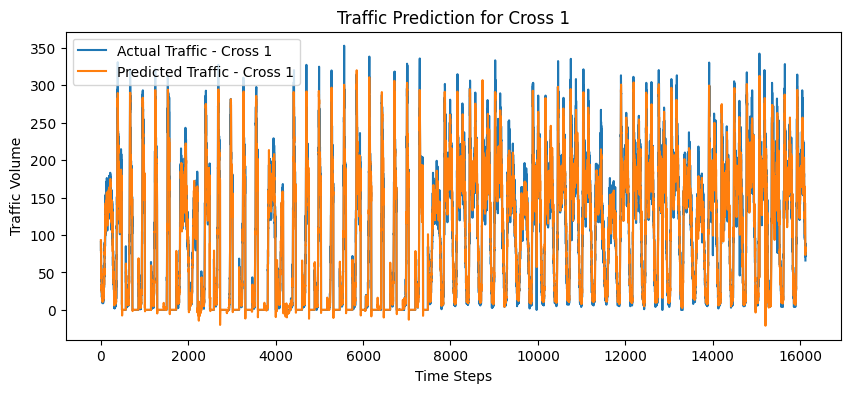

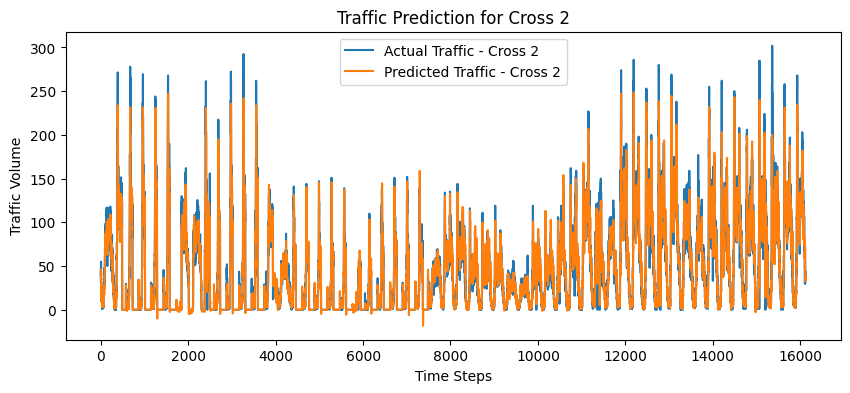

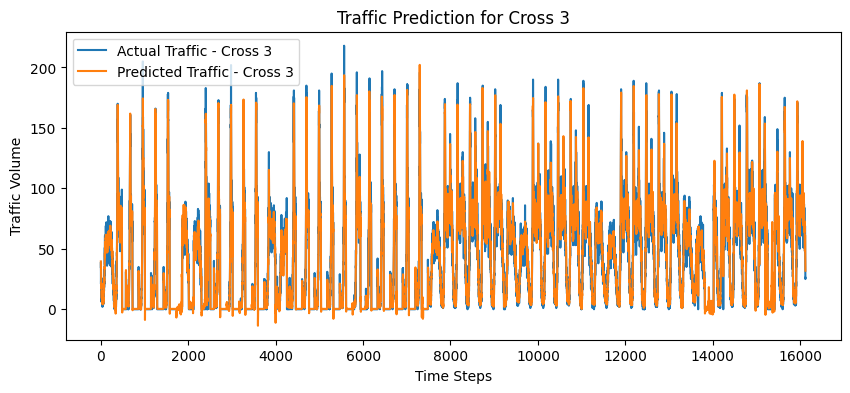

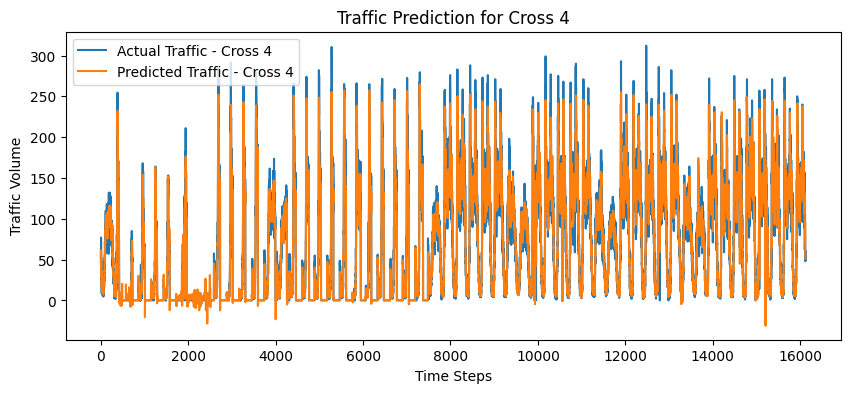

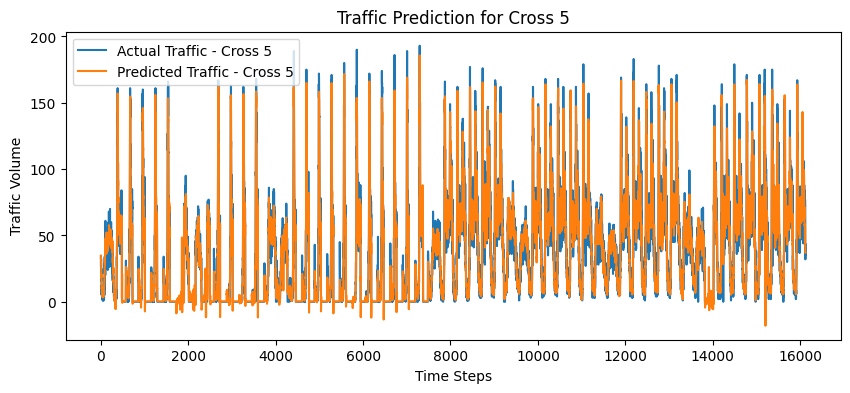

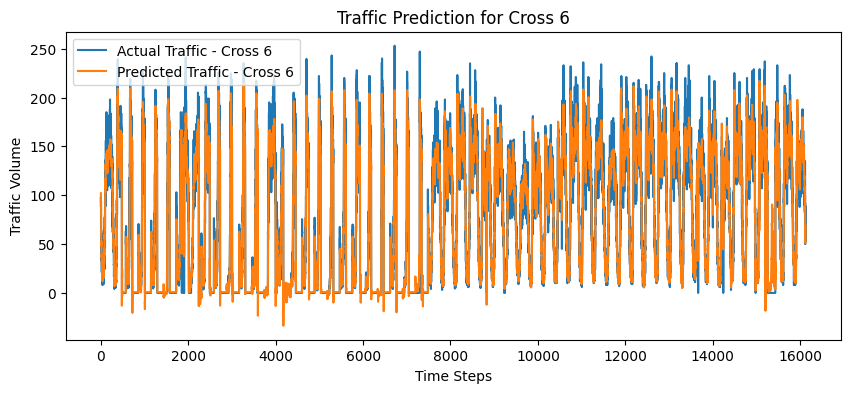

In [57]:
intersections = ['Cross 1', 'Cross 2', 'Cross 3', 'Cross 4', 'Cross 5', 'Cross 6']

for i, intersection in enumerate(intersections):
    plt.figure(figsize=(10, 4))
    plt.plot(actual_traffic[:, i], label=f'Actual Traffic - {intersection}')
    plt.plot(predicted_traffic[:, i], label=f'Predicted Traffic - {intersection}')
    plt.title(f'Traffic Prediction for {intersection}')
    plt.xlabel('Time Steps')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.show()

## Plotting the Graph for 1 Day

In [58]:
one_day_data = data.loc['2024-01-01']
actual_traffic_one_day = actual_traffic[:len(one_day_data)]
predicted_traffic_one_day = predicted_traffic[:len(one_day_data)]

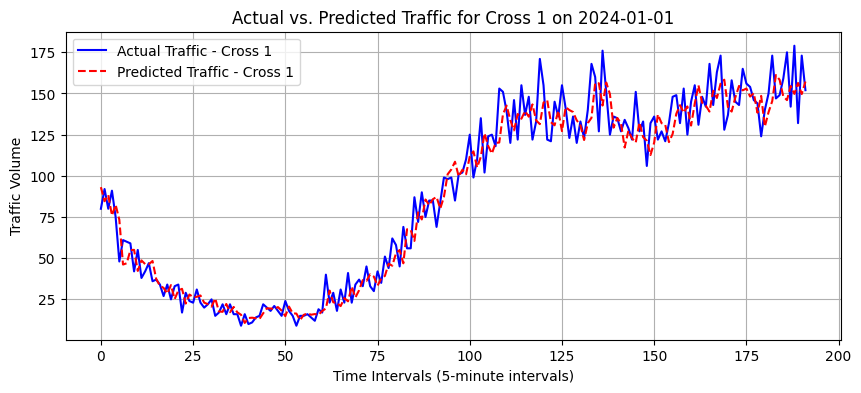

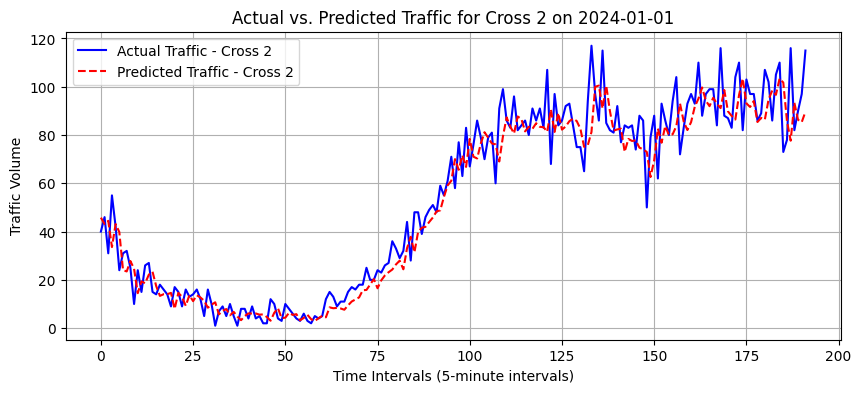

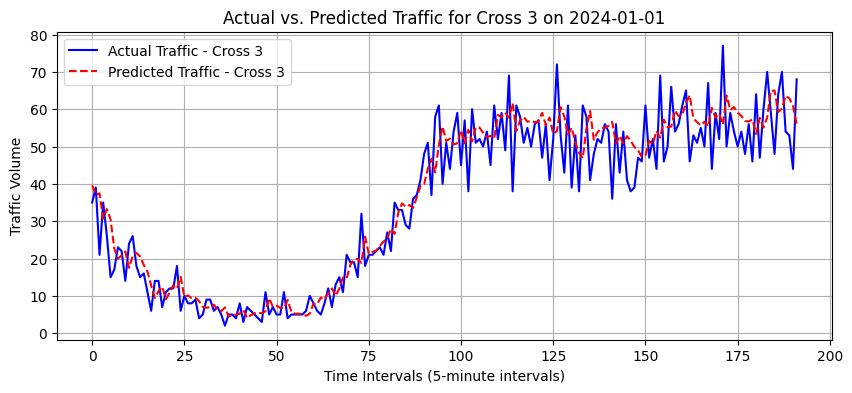

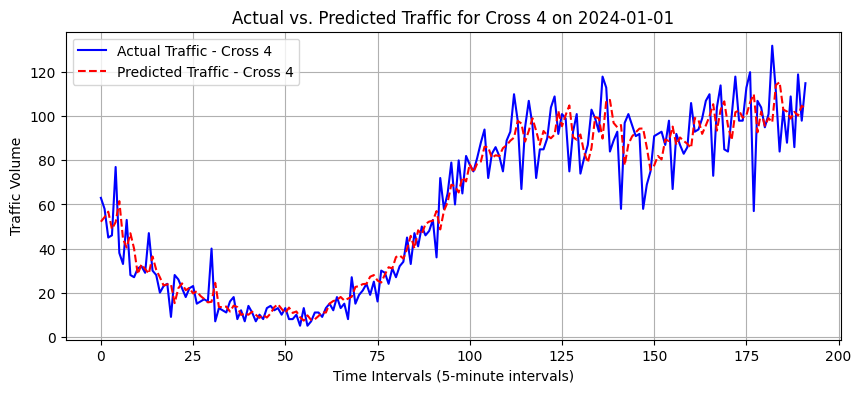

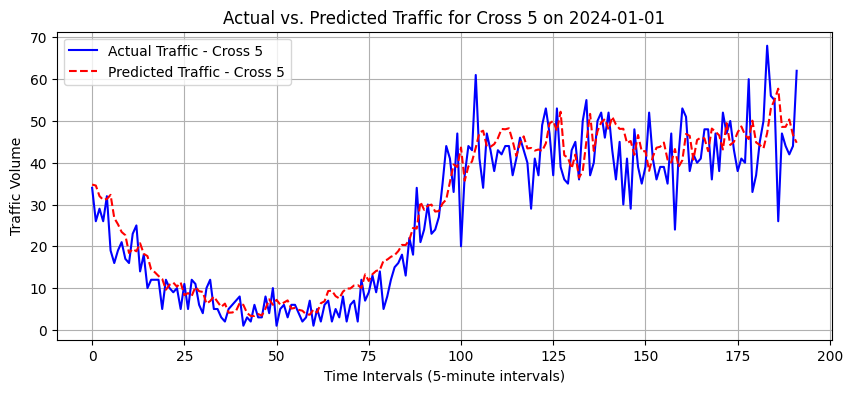

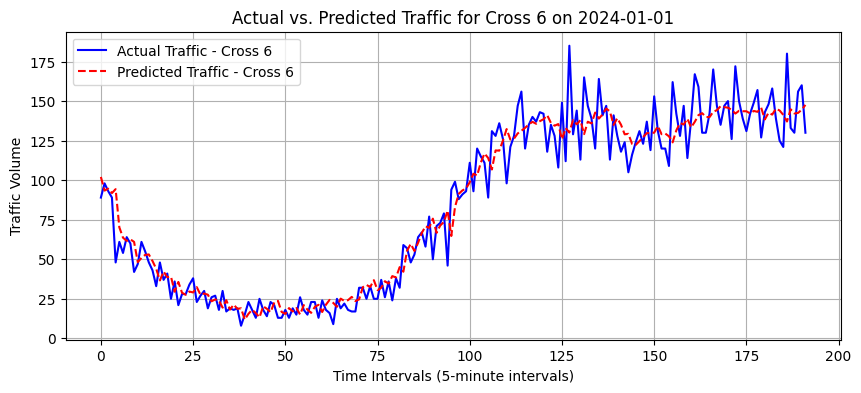

In [59]:
intersections = ['Cross 1', 'Cross 2', 'Cross 3', 'Cross 4', 'Cross 5', 'Cross 6']

for i, intersection in enumerate(intersections):
    plt.figure(figsize=(10, 4))
    plt.plot(actual_traffic_one_day[:, i], label=f'Actual Traffic - {intersection}', color='blue')
    plt.plot(predicted_traffic_one_day[:, i], label=f'Predicted Traffic - {intersection}', linestyle='dashed', color='red')
    plt.title(f'Actual vs. Predicted Traffic for {intersection} on 2024-01-01')
    plt.xlabel('Time Intervals (5-minute intervals)')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.grid(True)
    plt.show()